# Turbulence Intensity Modeling in a 3×3 Wind Farm


In [2]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

# Detect notebook working directory
notebook_cwd = os.getcwd()

# Project root = one level up from notebooks/
project_root = os.path.abspath(os.path.join(notebook_cwd, ".."))

# Add project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import modules
from src.turbine import Turbine
from src.wake_model import velocity_deficit, is_in_wake


In [3]:
# Load turbine specs
data_path = os.path.join(project_root, "data", "turbine_specs.json")
with open(data_path, "r") as f:
    specs = json.load(f)

D = specs["rotor_diameter"]
C_T = specs["thrust_coefficient"]
P_rated = specs["rated_power_kw"]

# Spacing: 5D
spacing = 5 * D

turbines = []
for i in range(3):
    for j in range(3):
        x = i * spacing
        y = j * spacing
        turbines.append(Turbine(x, y, D, C_T, P_rated))

turbines


In [4]:
def induction_factor(C_T):
    return 1 - np.sqrt(1 - C_T)

def turbulence_intensity(x, TI0, C_T, D):
    """
    TI(x) = TI0 + 0.73*a / (1 + 0.83*x/D)^2
    """
    a = induction_factor(C_T)
    return TI0 + (0.73 * a) / (1 + 0.83 * x / D)**2


In [5]:
TI0 = 0.08   # 8% ambient turbulence
U_inf = 8.0  # m/s
k = 0.04     # wake expansion coefficient

TI_values = []

for t in turbines:
    # Find upstream turbines
    upstream = [u for u in turbines if u.x < t.x]

    # If no upstream turbines → ambient TI
    if not upstream:
        TI_values.append(TI0)
        continue

    # Compute wake-added TI from each upstream turbine
    TI_additions = []
    for u in upstream:
        if is_in_wake(t.x, t.y, u.x, u.y, u.R, k):
            dx = t.x - u.x
            TI_additions.append(turbulence_intensity(dx, TI0, C_T, D))

    if TI_additions:
        TI_values.append(max(TI_additions))
    else:
        TI_values.append(TI0)

TI_values


[0.08,
 0.08,
 0.08,
 np.float64(0.0952147827423897),
 np.float64(0.0952147827423897),
 np.float64(0.0952147827423897),
 np.float64(0.0952147827423897),
 np.float64(0.0952147827423897),
 np.float64(0.0952147827423897)]

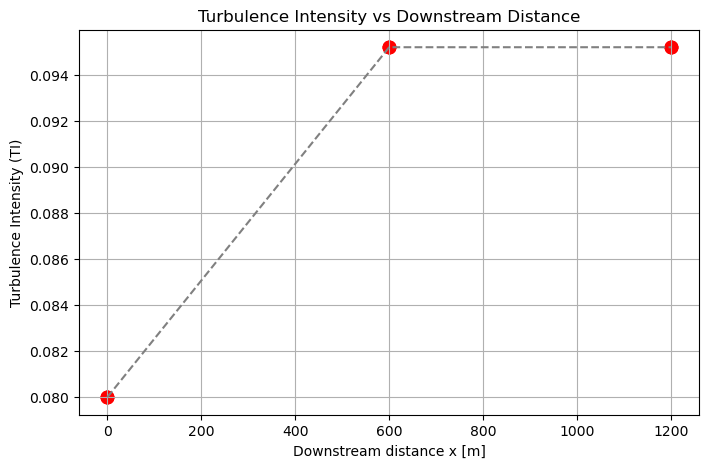

In [6]:
xs = [t.x for t in turbines]

plt.figure(figsize=(8, 5))
plt.scatter(xs, TI_values, c="red", s=80)
plt.plot(xs, TI_values, "--", color="gray")

plt.xlabel("Downstream distance x [m]")
plt.ylabel("Turbulence Intensity (TI)")
plt.title("Turbulence Intensity vs Downstream Distance")
plt.grid(True)

results_dir = os.path.join(project_root, "results")
os.makedirs(results_dir, exist_ok=True)

plt.savefig(os.path.join(results_dir, "turbulence_vs_distance.png"),
            dpi=300, bbox_inches="tight")
plt.show()


In [7]:
nx, ny = 200, 200

x_min = -0.5 * D
x_max = 10 * D + 0.5 * D
y_min = -0.5 * D
y_max = 10 * D + 0.5 * D

xs_grid = np.linspace(x_min, x_max, nx)
ys_grid = np.linspace(y_min, y_max, ny)

TI_field = np.zeros((ny, nx))

for i, y in enumerate(ys_grid):
    for j, x in enumerate(xs_grid):
        # Find upstream turbines
        upstream = [u for u in turbines if u.x < x]

        if not upstream:
            TI_field[i, j] = TI0
            continue

        TI_add = []
        for u in upstream:
            if is_in_wake(x, y, u.x, u.y, u.R, k):
                dx = x - u.x
                TI_add.append(turbulence_intensity(dx, TI0, C_T, D))

        TI_field[i, j] = max(TI_add) if TI_add else TI0


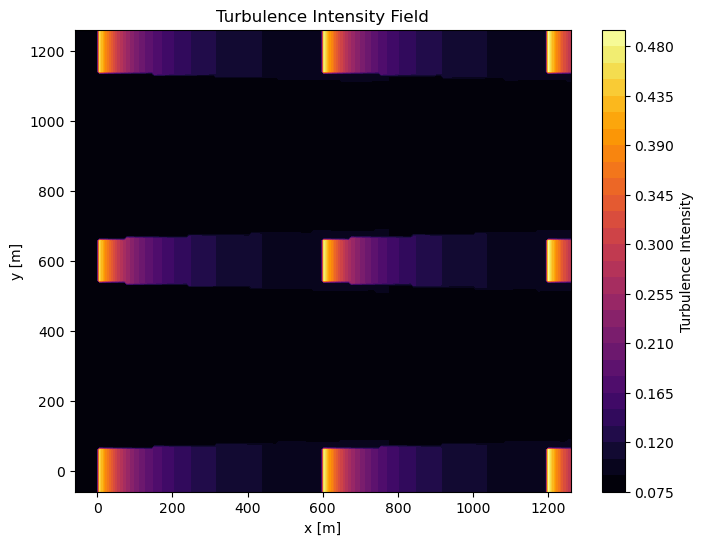

In [8]:
X, Y = np.meshgrid(xs_grid, ys_grid)

plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, TI_field, levels=30, cmap="inferno")
cbar = plt.colorbar(contour)
cbar.set_label("Turbulence Intensity")

plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Turbulence Intensity Field")

plt.savefig(os.path.join(results_dir, "turbulence_field.png"),
            dpi=300, bbox_inches="tight")
plt.show()
